# Data Preparation

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [6]:
## Reading in the dataframes. Train data and labels are stored in different CSV files.

train_data = pd.read_csv("data/train_data.csv", chunksize = 100000)
train_labels = pd.read_csv("data/train_labels.csv")

In [7]:
## This is a very large dataset, and training models on it is computationally expensive
## This cell reduces the size of the individual entries of the dataset to speed up processing

df2 = pd.DataFrame()
for df in train_data:
    cols = ['customer_ID', 'S_2', 'B_30', 'B_38', 'D_63', 'D_64', 'D_66', 'D_68', 'D_114', 'D_116', 'D_117', 'D_120', 'D_126']
    df['customer_ID'] = df['customer_ID'].apply(lambda x: int(x[-16:],16) ).astype('int32')
    df['S_2'] = pd.to_datetime(df['S_2'])
    df['B_30'] = df['B_30'].fillna(-1).astype('int8')
    df['B_38'] = df['B_38'].fillna(-1).astype('int8')
    df['D_63'] = df['D_63'].astype('category').cat.codes.astype('int8')
    df['D_64'] = df['D_64'].astype('category').cat.codes.astype('int8')
    df['D_66'] = df['D_66'].astype('category').cat.codes.astype('int8')
    df['D_68'] = df['D_68'].astype('category').cat.codes.astype('int8')
    df['D_114'] = df['D_114'].fillna(-1).astype('int8')
    df['D_116'] = df['D_116'].fillna(-1).astype('int8')
    df['D_117'] = df['D_117'].fillna(-1).astype('int8')
    df['D_120'] = df['D_120'].fillna(-1).astype('int8')
    df['D_126'] = df['D_126'].fillna(-1).astype('int8')
    for c in df.columns:
        if c not in cols:
            df[c] = df[c].fillna(-1).astype('int16')
    df2 = pd.concat([df2, df])

In [8]:
print("Total number of rows in train_data : ", len(df2))
print("Total number of unique customers in train_data : ", len(df2['customer_ID'].unique()))

Total number of rows in train_data :  5531451
Total number of unique customers in train_data :  458884


In [50]:
## This function removes all missing values from the dataframe
## This includes np.nan and -1 entries

def handle_nan_values(df, missing_values=[np.nan, -1]):
    df.replace(missing_values, np.nan, inplace=True)
    nan_percentage = (df.isna().sum() / len(df)) * 100
    columns_to_drop = nan_percentage[nan_percentage > 50].index
    df = df.drop(columns=columns_to_drop)
    df = df.apply(lambda col: col.fillna(col.mean()) if col.isna().any() else col)
    return df

In [51]:
df2 = handle_nan_values(df2)

In [9]:
## Get lists of the categorical, time, and numerical columns in the dataframe
## This will be useful in data aggregation

cat_cols = ['B_30', 'B_38', 'D_114', 'D_116', 'D_117', 'D_120', 'D_126', 'D_63', 'D_64', 'D_68']
time_col = ['S_2']
id_col = ['customer_ID']
numeric_cols = []
for col in df2.columns:
    if col not in cat_cols and col not in time_col and col not in id_col:
        numeric_cols.append(col)

print(len(numeric_cols))

177


In [10]:
## One of the aggregation steps involves finding the most recent value of each catergorial column according to date

last_values_df = df2.sort_values(by=['customer_ID', 'S_2']).groupby('customer_ID').last()

# Rename the columns to indicate they are the last values
last_values_df.columns = [f'{col}_last' for col in last_values_df.columns]

In [11]:
columns_to_aggregate = numeric_cols 

# Define aggregation functions for each numerical column
aggregation_functions = {
    col: ['mean', 'std', 'min', 'max'] for col in columns_to_aggregate
}

print(aggregation_functions)

# Aggregating the dataframe's numerical values
# Only numerical features appear in the resulting dataframe
aggregated_df = df2.groupby('customer_ID').agg(aggregation_functions).reset_index()
aggregated_df.columns = ['_'.join(col).strip() for col in aggregated_df.columns.values]

aggregated_df.rename(columns={'customer_ID_': 'customer_ID'}, inplace=True)
train_labels['customer_ID'] =train_labels['customer_ID'].apply(lambda x: int(x[-16:],16) ).astype('int32')

{'P_2': ['mean', 'std', 'min', 'max'], 'D_39': ['mean', 'std', 'min', 'max'], 'B_1': ['mean', 'std', 'min', 'max'], 'B_2': ['mean', 'std', 'min', 'max'], 'R_1': ['mean', 'std', 'min', 'max'], 'S_3': ['mean', 'std', 'min', 'max'], 'D_41': ['mean', 'std', 'min', 'max'], 'B_3': ['mean', 'std', 'min', 'max'], 'D_42': ['mean', 'std', 'min', 'max'], 'D_43': ['mean', 'std', 'min', 'max'], 'D_44': ['mean', 'std', 'min', 'max'], 'B_4': ['mean', 'std', 'min', 'max'], 'D_45': ['mean', 'std', 'min', 'max'], 'B_5': ['mean', 'std', 'min', 'max'], 'R_2': ['mean', 'std', 'min', 'max'], 'D_46': ['mean', 'std', 'min', 'max'], 'D_47': ['mean', 'std', 'min', 'max'], 'D_48': ['mean', 'std', 'min', 'max'], 'D_49': ['mean', 'std', 'min', 'max'], 'B_6': ['mean', 'std', 'min', 'max'], 'B_7': ['mean', 'std', 'min', 'max'], 'B_8': ['mean', 'std', 'min', 'max'], 'D_50': ['mean', 'std', 'min', 'max'], 'D_51': ['mean', 'std', 'min', 'max'], 'B_9': ['mean', 'std', 'min', 'max'], 'R_3': ['mean', 'std', 'min', 'max'],

In [12]:
## The variable name "final_df" is misleading; we are still missing the mode

final_df = pd.merge(aggregated_df, last_values_df, left_on='customer_ID', right_index=True)
final_df

,customer_ID,P_2_mean,P_2_std,P_2_min,P_2_max,D_39_mean,D_39_std,D_39_min,D_39_max,B_1_mean,...,D_136_last,D_137_last,D_138_last,D_139_last,D_140_last,D_141_last,D_142_last,D_143_last,D_144_last,D_145_last
0,-2147467588,0.000000,0.000000,0,0,0.000000,0.00000,0,0,0.0,...,-1,-1,-1,0,0,0,-1,0,0,0
1,-2147461914,0.000000,0.000000,0,0,0.076923,0.27735,0,1,0.0,...,-1,-1,-1,1,0,1,0,1,0,0
2,-2147456568,0.000000,0.000000,0,0,0.000000,0.00000,0,0,0.0,...,-1,-1,-1,1,0,0,0,1,0,0
3,-2147448814,0.000000,0.000000,0,0,0.000000,0.00000,0,0,0.0,...,-1,-1,-1,0,0,0,-1,0,0,0
4,-2147448315,0.000000,0.000000,0,0,0.000000,0.00000,0,0,0.0,...,-1,-1,-1,0,0,0,-1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
458879,2147393588,0.000000,0.000000,0,0,0.000000,0.00000,0,0,0.0,...,-1,-1,-1,1,0,0,0,1,0,0
458880,2147411856,0.000000,0.000000,0,0,0.000000,0.00000,0,0,0.0,...,-1,-1,-1,1,0,0,0,1,0,0
458881,2147464011,0.153846,0.375534,0,1,0.000000,0.00000,0,0,0.0,...,-1,-1,-1,0,0,0,-1,0,0,0
458882,2147464257,0.000000,0.000000,0,0,0.000000,0.00000,0,0,0.0,...,-1,-1,-1,0,0,0,-1,0,0,0


In [13]:
## Aggregating the mode for categorical columns

mode_aggregation = { col: [('mode', lambda x: x.mode().iat[0])] for col in cat_cols }
mode_df = df2.groupby('customer_ID').agg(mode_aggregation).reset_index()
mode_df.columns = [f'{col}_{agg}' for col, agg in mode_df.columns]

In [17]:
# Fixing naming issue
mode_df=mode_df.rename(columns={"customer_ID_":"customer_ID"})
mode_df

,customer_ID,B_30_mode,B_38_mode,D_114_mode,D_116_mode,D_117_mode,D_120_mode,D_126_mode,D_63_mode,D_64_mode,D_66_mode,D_68_mode
0,-2147467588,0,1,-1,-1,-1,-1,-1,1,-1,-1,-1
1,-2147461914,1,3,0,0,-1,1,1,1,3,1,6
2,-2147456568,0,7,0,0,-1,0,1,1,3,-1,6
3,-2147448814,0,5,0,0,-1,0,0,1,1,-1,2
4,-2147448315,0,4,0,0,3,0,0,1,3,-1,2
...,...,...,...,...,...,...,...,...,...,...,...,...
458879,2147393588,0,1,0,0,-1,1,0,1,3,-1,2
458880,2147411856,1,6,1,0,2,0,1,1,1,-1,6
458881,2147464011,0,1,1,0,2,0,1,1,1,-1,6
458882,2147464257,0,3,0,0,4,0,-1,1,1,-1,6


In [18]:
# Merging labels and values
merged_df = pd.merge(final_df, train_labels, on='customer_ID')
merged_df = merged_df.drop_duplicates(subset='customer_ID')
# Merging mode aggregation
merged_df = pd.merge(merged_df, mode_df, on='customer_ID')

In [19]:
merged_df

,customer_ID,P_2_mean,P_2_std,P_2_min,P_2_max,D_39_mean,D_39_std,D_39_min,D_39_max,B_1_mean,...,B_38_mode,D_114_mode,D_116_mode,D_117_mode,D_120_mode,D_126_mode,D_63_mode,D_64_mode,D_66_mode,D_68_mode
0,-2147467588,0.000000,0.000000,0,0,0.000000,0.00000,0,0,0.0,...,1,-1,-1,-1,-1,-1,1,-1,-1,-1
1,-2147461914,0.000000,0.000000,0,0,0.076923,0.27735,0,1,0.0,...,3,0,0,-1,1,1,1,3,1,6
2,-2147456568,0.000000,0.000000,0,0,0.000000,0.00000,0,0,0.0,...,7,0,0,-1,0,1,1,3,-1,6
3,-2147448814,0.000000,0.000000,0,0,0.000000,0.00000,0,0,0.0,...,5,0,0,-1,0,0,1,1,-1,2
4,-2147448315,0.000000,0.000000,0,0,0.000000,0.00000,0,0,0.0,...,4,0,0,3,0,0,1,3,-1,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
458879,2147393588,0.000000,0.000000,0,0,0.000000,0.00000,0,0,0.0,...,1,0,0,-1,1,0,1,3,-1,2
458880,2147411856,0.000000,0.000000,0,0,0.000000,0.00000,0,0,0.0,...,6,1,0,2,0,1,1,1,-1,6
458881,2147464011,0.153846,0.375534,0,1,0.000000,0.00000,0,0,0.0,...,1,1,0,2,0,1,1,1,-1,6
458882,2147464257,0.000000,0.000000,0,0,0.000000,0.00000,0,0,0.0,...,3,0,0,4,0,-1,1,1,-1,6


In [ ]:
## Changing the type of S_2_last such that it may be interpreted by models

merged_df = merged_df.drop(columns=['Unnamed: 0'])
merged_df['S_2_last'] = pd.to_datetime(merged_df['S_2_last']).astype('int64')

In [14]:
merged_df.to_csv("data/default.csv")

In [16]:
default_df = pd.read_csv("data/default.csv")

# Tree-based model training

In [4]:
from sklearn.model_selection import train_test_split

In [5]:
values = default_df.drop(columns=['Unnamed: 0', 'target'])
labels = default_df['target']

In [6]:
train_X, test_X, train_Y, test_Y = train_test_split(values, labels, test_size=0.2, random_state = 42, stratify=labels)

In [7]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

In [59]:
baseline_DT = DecisionTreeClassifier(random_state=42)
baseline_RF = RandomForestClassifier(random_state=42)

### Baseline decision tree

In [60]:
baseline_DT.fit(train_X, train_Y)
baseDT_preds = baseline_DT.predict(test_X)
base_DT_accuracy = accuracy_score(test_Y, baseDT_preds)
classification_report_str = classification_report(test_Y, baseDT_preds)

print(f"Baseline decision tree accuracy: {base_DT_accuracy}")
print(f"Baseline decision tree classification report:\n {classification_report_str}")

Baseline decision tree accuracy: 0.8210126058202499
Baseline decision tree classification report:
               precision    recall  f1-score   support

           0       0.88      0.88      0.88     68017
           1       0.66      0.65      0.65     23766

    accuracy                           0.82     91783
   macro avg       0.77      0.77      0.77     91783
weighted avg       0.82      0.82      0.82     91783



### Baseline random forest

In [61]:
baseline_RF.fit(train_X, train_Y)
baseRF_preds = baseline_RF.predict(test_X)
base_RF_accuracy = accuracy_score(test_Y, baseRF_preds)
base_RF_classRep = classification_report(test_Y, baseRF_preds)

print(f"Baseline random forest accuracy: {base_RF_accuracy}")
print(f"Baseline random forest classification report:\n {base_RF_classRep}")

Baseline decision tree accuracy: 0.8751838575771113
Baseline decision tree classification report:
               precision    recall  f1-score   support

           0       0.91      0.93      0.92     68017
           1       0.77      0.73      0.75     23766

    accuracy                           0.88     91783
   macro avg       0.84      0.83      0.83     91783
weighted avg       0.87      0.88      0.87     91783



### Baseline Adaboost

In [8]:
from sklearn.ensemble import AdaBoostClassifier

In [9]:
baseline_ada = AdaBoostClassifier(random_state=42)
baseline_ada.fit(train_X, train_Y)
baseAda_preds = baseline_ada.predict(test_X)
base_Ada_accuracy = accuracy_score(test_Y, baseAda_preds)
base_Ada_classRep = classification_report(test_Y, baseAda_preds)

print(f"Baseline Adaboost model accuracy: {base_Ada_accuracy}")
print(f"Baseline Adaboost model classification report:\n {base_Ada_classRep}")

Baseline Adaboost model accuracy: 0.8684614797947332
Baseline Adaboost model classification report:
               precision    recall  f1-score   support

           0       0.90      0.93      0.91     68017
           1       0.77      0.70      0.73     23766

    accuracy                           0.87     91783
   macro avg       0.84      0.81      0.82     91783
weighted avg       0.87      0.87      0.87     91783



### Baseline HistGradientBoosting

In [10]:
from sklearn.ensemble import HistGradientBoostingClassifier

In [11]:
baseline_HGB = HistGradientBoostingClassifier(random_state=42)
baseline_HGB.fit(train_X, train_Y)
baseHGB_preds = baseline_HGB.predict(test_X)
base_HGB_accuracy = accuracy_score(test_Y, baseHGB_preds)
base_HGB_classRep = classification_report(test_Y, baseHGB_preds)

print(f"Baseline HistGradientBoosting model accuracy: {base_HGB_accuracy}\n")
print(f"Baseline HistGradientBoosting model classification report:\n {base_HGB_classRep}")

Baseline HistGradientBoosting model accuracy: 0.8794983820533214

Baseline HistGradientBoosting model classification report:
               precision    recall  f1-score   support

           0       0.91      0.93      0.92     68017
           1       0.78      0.75      0.76     23766

    accuracy                           0.88     91783
   macro avg       0.85      0.84      0.84     91783
weighted avg       0.88      0.88      0.88     91783



### Baseline XGBoost

In [8]:
from xgboost import XGBClassifier

In [11]:
baseline_XGB = XGBClassifier(random_state=42)
baseline_XGB.fit(train_X, train_Y)
baseXGB_preds = baseline_XGB.predict(test_X)
base_XGB_accuracy = accuracy_score(test_Y, baseXGB_preds)
base_XGB_classRep = classification_report(test_Y, baseXGB_preds)

print(f"Baseline XGBoost model accuracy: {base_XGB_accuracy}\n")
print(f"Baseline XGBoost model classification report:\n {base_XGB_classRep}")

Baseline XGBoost model accuracy: 0.8797271825937265

Baseline XGBoost model classification report:
               precision    recall  f1-score   support

           0       0.91      0.93      0.92     68017
           1       0.78      0.74      0.76     23766

    accuracy                           0.88     91783
   macro avg       0.85      0.84      0.84     91783
weighted avg       0.88      0.88      0.88     91783



# Non-tree-based model training

### Baseline logistic regression with l2 normalization

In [21]:
from sklearn.linear_model import LogisticRegression

In [23]:
baseline_LR = LogisticRegression(penalty='l2', random_state=42)
baseline_LR.fit(train_X, train_Y)
baseLR_preds = baseline_LR.predict(test_X)
base_LR_accuracy = accuracy_score(test_Y, baseLR_preds)
base_LR_classRep = classification_report(test_Y, baseLR_preds)

print(f"Baseline logistic regression (l2 normalization) accuracy: {base_LR_accuracy}\n")
print(f"Baseline logistic regression (l2 normalization) classification report:\n {base_LR_classRep}")

Baseline logistic regression (l2 normalization) accuracy: 0.7410631598444156

Baseline logistic regression (l2 normalization) classification report:
               precision    recall  f1-score   support

           0       0.74      1.00      0.85     68017
           1       0.00      0.00      0.00     23766

    accuracy                           0.74     91783
   macro avg       0.37      0.50      0.43     91783
weighted avg       0.55      0.74      0.63     91783



/Users/fernandonotari/opt/anaconda3/envs/AML/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/fernandonotari/opt/anaconda3/envs/AML/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/fernandonotari/opt/anaconda3/envs/AML/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

### Baseline RBF Kernel SVM

In [24]:
from sklearn.svm import SVC

In [25]:
baseline_SVMrbf = SVC(kernel='rbf', random_state=42)
baseline_SVMrbf.fit(train_X, train_Y)
baseSVMrbf_preds = baseline_LR.predict(test_X)
base_SVMrbf_accuracy = accuracy_score(test_Y, baseSVMrbf_preds)
base_SVMrbf_classRep = classification_report(test_Y, baseSVMrbf_preds)

print(f"Baseline RBF kernel SVM accuracy: {base_SVMrbf_accuracy}\n")
print(f"Baseline RBF kernel SVM classification report:\n {base_SVMrbf_classRep}")

#### I trained this model for 200 minutes and my kernel timed out. I do not think pursuing this is efficient for the purposes of this project, especially because it is unlikely that it will perform better than the other models we tried.

# BEST MODEL: XGBoost Classifier

### Model evaluation plots

In [12]:
from sklearn.metrics import roc_curve, precision_recall_curve, auc

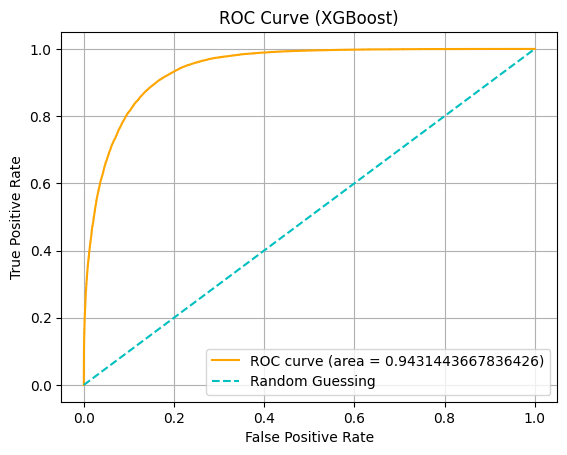

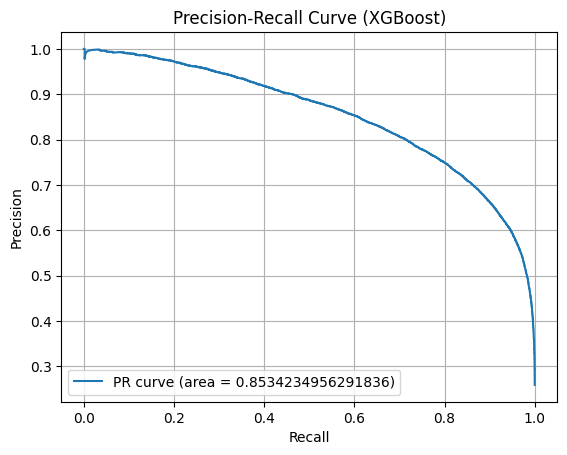

In [24]:
XGBlabel_probabilities = baseline_XGB.predict_proba(test_X)[:, 1]

fpr, tpr, _ = roc_curve(test_Y, XGBlabel_probabilities)
roc_auc = auc(fpr, tpr)
precision, recall, _ = precision_recall_curve(test_Y, XGBlabel_probabilities)
pr_auc = auc(recall, precision)
ROClabel = f"ROC curve (area = {roc_auc})"
PRlabel = f"PR curve (area = {pr_auc})"

plt.figure()
plt.plot(fpr, tpr, color='orange', label=ROClabel)
plt.plot([0, 1], [0, 1], color='c', linestyle='--', label='Random Guessing')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve (XGBoost)')
plt.legend(loc='lower right')
plt.grid()
plt.show()
plt.figure()
plt.plot(recall,precision,label=PRlabel)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve (XGBoost)')
plt.legend(loc='lower left')
plt.grid()
plt.show()